In [1]:
from __future__ import print_function
from collections import namedtuple
import os
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from src.utils import normalize, setup_dataset
from skimage import color
%matplotlib inline

def convert(dictionary):
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

In [7]:
torch.cuda.set_device(0)

DATASET = 'colorization'
dtype = torch.FloatTensor
opt=({      
         'nz':24, 
         'nout':16,
         'dataroot': '/home/dulyanov/data/MSCOCO/dataset1/',
         'ngf':64, 
         'ndf': 64, 
         'noise': 'sphere',
         'ngpu': 1,
         'dataset': 'colorization_',
         'image_size':64,
         'workers':1,
         'batch_size': 64,
         'nc':3
        })

# if DATASET=='cifar10':
#     # default params work for cifar
#     pass
# elif DATASET=='celeba':
#     opt.update({      
#              'nz':64, 
#              'dataset': 'celeba',
#              'dataroot': '/sdh/data/celebA/imgs1', # put here your path
#              'image_size':64, 
#             })

# opt['nc'] =  3
opt= convert(opt)

# Load g,e
E_path = 'data/checkpoints/color_coco/netE_epoch_154.pth'
G_path = 'data/checkpoints/color_coco/netG_epoch_154.pth'

netG = torch.load(G_path).type(dtype)
netE = torch.load(E_path).type(dtype)
    
netG.eval()
netE.eval()

_netE_Base (
  (main): Sequential (
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(512, 24, kernel_size=(4, 4), stride=(1, 1))
  )
)

# Sample

In [8]:
def deprocess(tensor):
    if 'colorization' in opt.dataset:
        out = torch.FloatTensor(*tensor.size())

        for i in range(tensor.size(0)):
            this = tensor[i].transpose(0, 2).contiguous().numpy()

            color.colorconv.lab_ref_white = np.array([0.96422, 1.0, 0.82521])

            out[i] = torch.FloatTensor(
                color.lab2rgb(this.astype(np.float64))).transpose(0, 2).contiguous()
        return out
    else:
        return tensor / 2 + 0.5

def conditional(x):
    return x[:, :1, :, :].clone()

/home/dulyanov/miniconda2/lib/python2.7/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


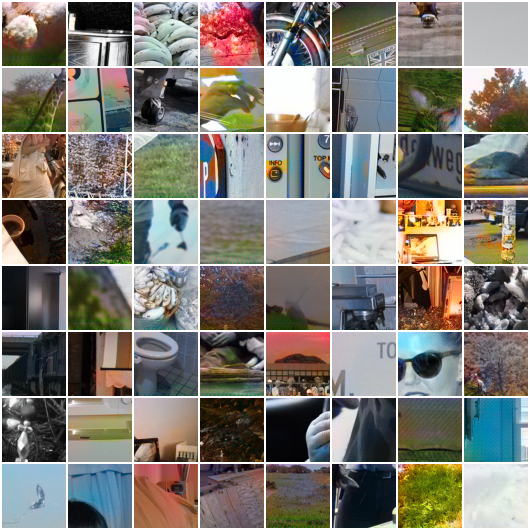

In [9]:
dataloader = setup_dataset(opt, train=True)
d = dataloader.next()
x = Variable(d[0], volatile=True)

z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

samples = netG(conditional(x), z).data.cpu()


grid = torchvision.utils.make_grid(deprocess(samples), pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

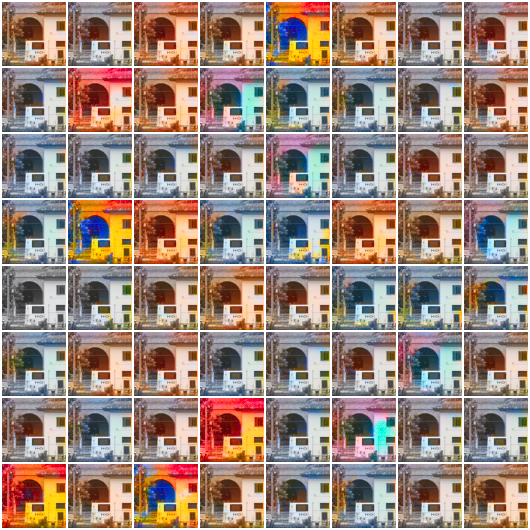

In [10]:
dataloader = setup_dataset(opt, train=False)
d = dataloader.next()
for i in range(1,d[0].size(0)):
    d[0][i] = d[0][0]
x = Variable(d[0], volatile=True)

z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

samples = netG(conditional(x), z).data.cpu()


grid = torchvision.utils.make_grid(deprocess(samples), pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

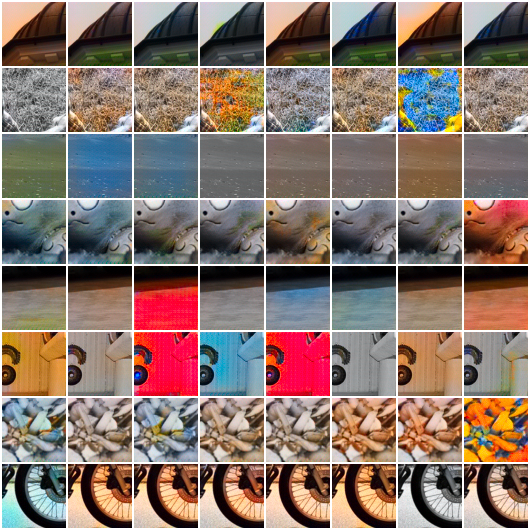

In [11]:
dataloader = setup_dataset(opt, train=True)
d = dataloader.next()
for j in range(0,63,8):
    for i in range(8):
        d[0][j+i] = d[0][j]
        
x = Variable(d[0], volatile=True)

z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

samples = netG(conditional(x), z).data.cpu()


grid = torchvision.utils.make_grid(deprocess(samples), pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL